In [145]:
import  gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import numpy as np  

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from IPython.display import clear_output

In [146]:
env = gym.make("LunarLander-v2", render_mode = "human")
env.reset()
env.render()
NUM_ACTIONS = env.action_space.n

### Exploring the observation space 

In [147]:
observation_space = env.observation_space
observation_space

Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)

Our observation is represented by an 8-dimensional box. Above, the first array indicates the lower bounds for different parameters whereas the second array specifies the upper bounds for those same parameters. Our 8 parameters in this case are: 

- Position X: Horizontal coordinate
- Position Y: Vertical coordinate
- Velocity X: Horizontal speed
- Velocity Y: Vertical speed
- Angle: The angle at which the lander is pointed
- Angular Velocity: The speed at which the angle is changing
- Left leg contact: Boolean value (1 if the left leg is in contact with the ground, 0 otherwise)
- Right leg contact: Boolean value (1 if the right leg is in contact with the ground, 0 otherwise)

### Building a class for our replay buffer

In [148]:
#named tuple to store experience 
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

#Experience replay buffer object 
class ReplayMemory(object):

    def __init__(self, capacity):
        #contains a deque of specified buffer length 
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        #add new transition to buffer 
        self.memory.append(Transition(*args))

    #simple function to sample some experience from memory randomly 
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

### Defining our Deep Q-Network

In [149]:
class DQN(nn.Module):

    def __init__(self, len_observation_space, n_actions):
        super(DQN, self).__init__()
        #observations to 128 
        self.layer1 = nn.Linear(len_observation_space, 128)
        #linear transformation 
        self.layer2 = nn.Linear(128, 128)
        #linear downsizing to number of possible actions 
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

### Policy function

In [150]:
def policy_fn(num_actions, e, state, policy_network):
    
    action_probabilities = torch.ones(num_actions).to(state.device) * (e/num_actions)

    with torch.no_grad(): 
        highest_action_value = policy_network(state).max(1)[1].item()

    action_probabilities[highest_action_value] += (1 - e)
    
    return action_probabilities

### Optimization Function Overview

The following function represents the optimization steps. If our replay buffer is at capacity, we:

- Sample a batch of transitions from memory. This initial step involves drawing a selection of varied transitions from our repository of stored experiences.

- Compute the expected value using the policy network. This step requires us to determine probable outcomes and their associated probabilities, based on our current policy.

- Compute target values by adding the observed reward to the expected next state value. This expected next state value is calculated using the target network instead of the policy network. 

- Compute the loss between the predicted and target values and then optimize the policy network. This final step is crucial for improving the predictive accuracy of our model. It works by learning from the discrepancies between predicted and actual outcomes, and uses these insights to refine the model.

Through this sequence of steps, the function continuously enhances the model's predictive performance by learning from past errors.


In [151]:
def optimize_model(gamma, batch_size, memory, policy_network, target_network, loss_fn, optimizer, device):
    
    if len(memory) < batch_size:
        return
    
    transitions = memory.sample(batch_size)
    batch = Transition(*zip(*transitions)) #batches our data as follows: ((state1, state2, ..), (action1, action2, ...), ...)
    
    non_final_mask = torch.tensor([s is not None for s in batch.next_state],
                                  device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    
    states = torch.cat(batch.state)
    actions = torch.cat(batch.action)
    rewards = torch.cat(batch.reward)
    
    actions = actions.unsqueeze(-1)
    predicted_values = policy_network(states).gather(1, actions) #gathers all max value actions for actions in batch
    next_state_values = torch.zeros(batch_size, device=device)
    
    with torch.no_grad():
        next_state_values[non_final_mask] = target_network(non_final_next_states).max(1)[0] #we use our target network with our 
                                                                                            #sampled reward to give us a bootstrapped target
    
    target_values = (next_state_values * gamma) +rewards # if the state is non terminal, we add to it the expected value of the next state 
    
    loss = loss_fn(predicted_values, target_values.unsqueeze(1))
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_network.parameters(), 100)
    optimizer.step()

In [152]:
def trainer(num_episodes, batch_size, target_network, policy_network, gamma, epsilon, device, replay_buffer, optimizer, tau): 
    
    reward_per_episode = []

    for episode in range(num_episodes): 
        
        state, _ = env.reset()
        state = torch.tensor(state, dtype=torch.float32, device = device).unsqueeze(0)
        episode_end = False
        step = 0 
        cum_reward = 0

        if  not episode % 500 and episode < 2000: 
            epsilon-=0.1

        while not episode_end: 
            
            action_probs = policy_fn(NUM_ACTIONS, epsilon, state, policy_network)
            action = np.random.choice(np.arange(NUM_ACTIONS), p = action_probs.squeeze().cpu().numpy())
            next_state, reward, terminated, truncated, _ = env.step(action)
            step+=1
            cum_reward+=reward
            episode_end = terminated or truncated 
            
            if not terminated: 
                next_state = torch.tensor(next_state, dtype=torch.float32, \
                    device = device).unsqueeze(0) #we only care about next_state if the state is non terminal
            else: 
                next_state = None
            
            action = torch.tensor(action, dtype=torch.int64, device=device).unsqueeze(0)
            reward = torch.tensor(reward, dtype=torch.float32, device=device).unsqueeze(0)

            replay_buffer.push(state, action, next_state, reward)
            state = next_state
            
            optimize_model(gamma, batch_size, replay_buffer, policy_network, target_network,loss_fn=torch.nn.MSELoss(size_average=True), optimizer=optimizer, device=device)
            
            #extract network parameters for both networks 
            target_network_state_dict = target_network.state_dict()
            policy_network_state_dict = policy_network.state_dict()
            
            for key in policy_network_state_dict.keys():
                # θ′ ← τ θ + (1 −τ )θ′
                target_network_state_dict[key] = policy_network_state_dict[key]*tau + target_network_state_dict[key]*(1-tau)
                target_network.load_state_dict(target_network_state_dict)
            
        print("Episode: {} Score: {}".format(episode, cum_reward))
        reward_per_episode.append(cum_reward)
        clear_output(wait=True) # Clear the output of the current cell receiving output
        plt.plot(reward_per_episode)
        plt.title('Cumulative Reward per Episode')
        plt.xlabel('Episode')
        plt.ylabel('Cumulative Reward')
        plt.show()

In [153]:
#hyperparams 
NUM_EPISODES = 500
E = 0.5
GAMMA = 1
ALPHA = 3e-4
BATCH_SIZE = 8 
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [154]:
replay_buffer = ReplayMemory(1000)
policy_network = DQN(n_actions=NUM_ACTIONS, len_observation_space=8)
target_network = DQN(n_actions=NUM_ACTIONS, len_observation_space=8)
policy_network.to(DEVICE)
target_network.to(DEVICE)
target_network.load_state_dict(policy_network.state_dict())

<All keys matched successfully>

In [155]:
optimizer = torch.optim.Adam(policy_network.parameters(), lr=ALPHA)

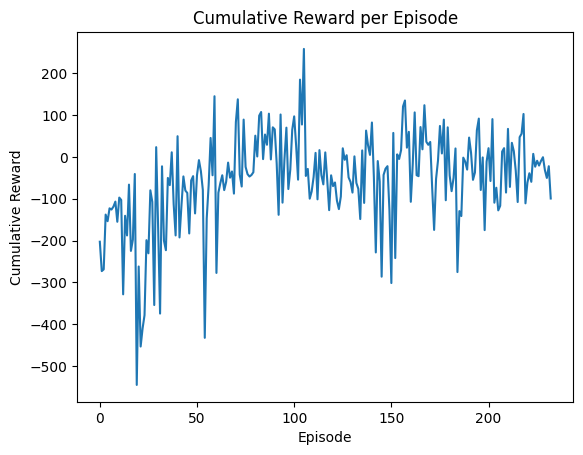

KeyboardInterrupt: 

In [156]:
trainer(num_episodes=NUM_EPISODES, batch_size=BATCH_SIZE, target_network=target_network, policy_network=policy_network, gamma=GAMMA, epsilon=E, device=DEVICE, replay_buffer=replay_buffer, optimizer=optimizer, tau=0.005)